In [1]:
import Pkg
Pkg.add("Plots")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


In [2]:
using LinearAlgebra, Random, Plots

In [3]:
random_seed = 11037

11037

## First data

[0.6868500031546817, 0.23098870111176473, 0.1085705250905491, 0.9507725237055039, 0.8608928605690106, 0.5581626815809725, 0.3927871036931271, 0.5852259829106462, 0.29463320717669683, 0.5374163563943153, 0.638376735349925, 0.6117994090874137, 0.42246964757913286, 0.21060262173122413, 0.885929135266597, 0.633843948738859, 0.7278848096053306, 0.9674393733218457, 0.6807001620447348, 0.9894095360669691, 0.37895497060789163, 0.6824816844863613, 0.9791949970867497, 0.7724665048075808, 0.3023610397927915, 0.3927987774668432, 0.10647199025192944, 0.14753458073050052, 0.4942846074494327, 0.054417186911917326]

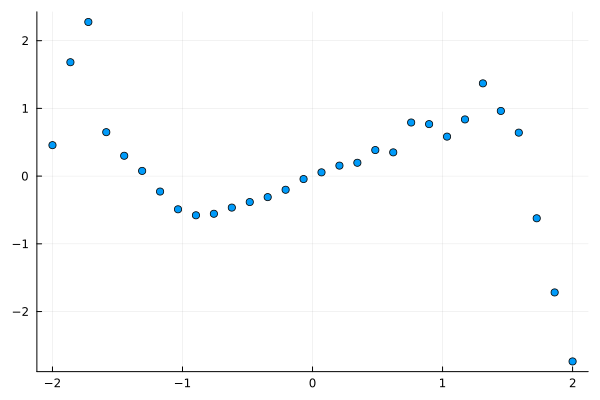

In [4]:
Random.seed!(random_seed)
n = 30
start = -2
stop = 2
eps = 1

x1 = range(start, stop, length=n)
r1 = rand(n) .* eps
print(r1)
y1 = x1.*( cos.(r1.+ 0.5.*x1.^3).+ sin.(0.5.*x1.^3) )

scatter(x1, y1, label="Data 1", legend=false, marker=:circle)

## Second data

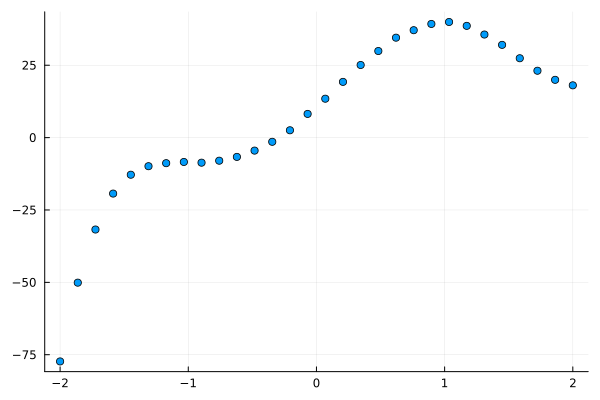

In [5]:
Random.seed!(random_seed)
n = 30
start = -2
stop = 2
eps = 1

x2 = range(start, stop, length=n)
r2 = rand(n) .* eps
y2 = 4 .* x2.^5 .- 5 .* x2.^4 .- 20 .* x2.^3 + 10 .* x2.^2 .+ 40 .* x2 .+ 10 .+ r2

scatter(x2, y2, label="Data 2", legend=false, marker=:circle)

## Solution

In [6]:
using LinearAlgebra

function gen_Vandermonde_matrix(m, n, input_data)
    """Make the matrix A with x_1, x_2, etc., raised to the power of 0, 1, 2, ..., up to m-1
    Makes a matrix with m columns and n rows (number of data points)
    """
    A = zeros(n, m)
    for exponent in 1:(m)
        A[:, exponent] = input_data[:].^(exponent-1)
    end
    return A
end

function back_substitution(U, b, m)
    """Solves the problem Ux = b for x via back substitution,
    where U is an upper triangular matrix
    """
    x = zeros(m)
    x[m] = b[m] / U[m, m]
    # from m-1 to 1 with step length -1 (so it counts m-1, m-2, ..., 2, 1)
    for i in (m-1):-1:1
        x[i] = (b[i] - sum(U[i, i+1:m] .* x[i+1:m])) / U[i, i]
    end
    return x
end

function QR_solution(A, b, m)
    """Uses QR factorization to find the x that minimizes the square error
    for a simple polynomial approximation of the problem Ax = b
    """
    Q1, R1 = qr(A)
    # return the reduced Q and R (Julia quirk with how qr function returns)
    Q1 = Matrix(Q1)
    R1 = Matrix(R1)
    rhs = Q1' * b
    x = back_substitution(R1, rhs, m)

    @assert isapprox(R1 * x, rhs) "R1 * x != Q1^T * b as expected"

    return x
end

function Cholesky_solution(A)
    """TODO
    """
    return 0
end

Cholesky_solution (generic function with 1 method)

In [11]:
polynomial_degrees = [3,8]
for m in polynomial_degrees
    println("\nData set 1")
    b1 = y1
    println("b1 is a $(size(b1)) vector")
    A1 = gen_Vandermonde_matrix(m, n, x1)
    println("A1 is a $(size(A1)) matrix")
    polynomial_coefficients = QR_solution(A1, b1, m)
    println("Output coefficients form a $(size(polynomial_coefficients)) vector")

    println("\nData set 2")
    b2 = y2
    println("b2 is a $(size(b2)) vector")
    A2 = gen_Vandermonde_matrix(m, n, x2)
    println("A2 is a $(size(A2)) matrix")
    polynomial_coefficients = QR_solution(A2, b2, m)
    println("Output coefficients form a $(size(polynomial_coefficients)) vector")
end


Data set 1
b1 is a (30,) vector
A1 is a (30, 3) matrix
Output coefficients form a (3,) vector

Data set 2
b2 is a (30,) vector
A2 is a (30, 3) matrix
Output coefficients form a (3,) vector

Data set 1
b1 is a (30,) vector
A1 is a (30, 8) matrix
Output coefficients form a (8,) vector

Data set 2
b2 is a (30,) vector
A2 is a (30, 8) matrix
Output coefficients form a (8,) vector
